### Deployment de Modelos

#### Paquetes a utilizar

In [345]:
import numpy as np
import pandas as pd
from joblib import load
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import tree
from scipy.stats import norm
import math

### Importar modelos

#### Modelo Árbol de Decisión

In [ ]:
tree_model = load('modelos/decisionTreeLog_varFare_varSex_varClass_20200629_102647.joblib') 

#### Modelo SVM

In [ ]:
svm_model = load('modelos/svmLog_varSex_varClass_20200629_102954.joblib') 

#### Modelo Naive Bayes

In [ ]:
mean = pd.read_csv('modelos/naiveBayesLog_varFare_varSex_varClass_20200629_104516/mean.csv')
stdev = pd.read_csv('modelos/naiveBayesLog_varFare_varSex_varClass_20200629_104516/stdev.csv')
probabilities = pd.read_csv('modelos/naiveBayesLog_varFare_varSex_varClass_20200629_104516/probabilities.csv')
y_class = pd.read_csv('modelos/naiveBayesLog_varFare_varSex_varClass_20200629_104516/class.csv')

bayes_model = {"mean":mean, "stdev":stdev, "probabilities":probabilities, "class":y_class}

#### Modelo Regresión Logística

In [312]:
reg_logistic_model = pd.read_csv('modelos/regLogisticLog_lr=0.0001_reg=0.01_bath_size=20_varSex_varClass_20200629_101316.csv')

#### Carga de datos de prueba

In [334]:
x_test = pd.read_csv('x_test.csv')
y_test = pd.read_csv('y_test.csv')

#### Funciones anexas para predecir los modelos de Naive Bayes y Regresión Logística

In [ ]:
def get_argmax(probability):
    max_value = 0
    argmax = -1
    for (key, value) in probability.items():
        if (key == 0):
            max_value = max(value)
            argmax = key
        else:
            tmp = max(value)
            if(max_value < tmp):
                max_value = tmp
                argmax = key
    return argmax

In [182]:
def predict_naive_bayes(model, x_test):
    y_predict = []
    for i in range(x_test.shape[0]):
        probability={}
        for y_class in model["class"].values:
            y_class = int(y_class)
            probability[y_class] = model["probabilities"].iloc[y_class][0]
            for index, _ in enumerate(x_test.iloc[i]):
                probability[y_class] *= norm.pdf(x_test.iloc[i], model["mean"].iloc[y_class, index], model["stdev"].iloc[y_class, index])
        y_predict.append(get_argmax(probability))
    return np.array(y_predict)

In [156]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [183]:
def predict_reg_logistic(model, x_test_):
    y_predict = []
    for feature in x_test_.values:
        value = 0
        for i in range(len(feature)):
            value += feature[i] * model[i][0]
        value_sigmoid = sigmoid(value)
        if value_sigmoid >= 0.5:
            y_predict.append(1)
        else:
            y_predict.append(0)
    return np.array(y_predict)

#### Función para cálculo de métricas

In [304]:
def get_metrics(y_true, y_predict):
    accuracy = accuracy_score(y_true, y_predict)
    error = mean_squared_error(y_true, y_predict)
    precision = precision_score(y_true, y_predict, average='weighted')
    recall = recall_score(y_true, y_predict, average='weighted')
    f1 = f1_score(y_true, y_predict, average="weighted")
    
    return np.array([accuracy, error, precision, recall, f1])

#### Función para determinar la moda de un conjunto de datos

In [265]:
def moda(data):
    repetitions = 0
    moda = -1
    for i in data:
        n = data.count(i)
        if n > repetitions:
            repetitions = n
    for i in data:
        n = data.count(i)
        if n == repetitions and moda == -1:
            moda = i     
    return moda

#### Función para obtener predición final en base a la moda de las predicciones individuales

In [285]:
def get_final_prediction(prediction_joined):
    moda_prediction = []
    for predict in prediction_joined:
        moda_predict = moda(list(predict))
        moda_prediction.append(moda_predict)
    return np.array(moda_prediction)

Debido a que el modelo generado con SVM y Regresión Logística se hizo en base a dos variables, se debe eliminar del set de datos la característica "Fare"

In [335]:
x_test_ = x_test.drop(['Fare'], axis=1)

#### Predición con el Modelo Árbol de Decisión

In [336]:
y_predict_tree = tree_model.predict(x_test)

#### Predición con el Modelo SVM


In [337]:
y_predict_svm = svm_model.predict(x_test_)

#### Predición con el Modelo Naive Bayes

In [338]:
y_predict_bayes = predict_naive_bayes(bayes_model, x_test)

#### Predición con el Modelo Regresión Logística

In [339]:
y_predict_reg_log = predict_reg_logistic(reg_logistic_model.values, x_test_)

#### Combinación de predicciones

In [340]:
y_predict_joined = np.stack((y_predict_tree, y_predict_svm, y_predict_bayes, y_predict_reg_log), axis=-1)

#### Obteniendo predicción en función de la moda

In [341]:
y_moda_predicted = get_final_prediction(y_predict_joined)

#### Tabla de Predicciones

In [342]:
y_prediction_summary = np.stack((y_predict_tree, y_predict_svm, y_predict_bayes, y_predict_reg_log, y_moda_predicted), axis=-1)
df_predictions = pd.DataFrame(y_prediction_summary, columns = ["Decision Tree","SVM","Bayes","Reg. Log.","Moda Predict"])
df_predictions

,Decision Tree,SVM,Bayes,Reg. Log.,Moda Predict
0,0,1,1,1,1
1,1,1,1,1,1
2,0,0,0,0,0
3,0,0,0,0,0
4,1,1,0,1,1
...,...,...,...,...,...
352,1,1,1,1,1
353,0,0,0,0,0
354,0,0,0,0,0
355,1,1,0,1,1


#### Cálculo de Métricas

In [343]:
metrics_tree = get_metrics(y_test, y_predict_tree)
metrics_svm = get_metrics(y_test, y_predict_svm)
metrics_bayes = get_metrics(y_test, y_predict_bayes)
metrics_reg_log = get_metrics(y_test, y_predict_reg_log)
metrics_moda_predicted = get_metrics(y_test, y_moda_predicted)
metrics_joined = np.stack((metrics_tree, metrics_svm, metrics_bayes, metrics_reg_log, metrics_moda_predicted), axis=-1)

#### Tabla de Métricas

In [344]:
df_metrics = pd.DataFrame(metrics_joined, index = ["Accuracy","Error","Precision","Recall","F1"], 
                          columns = ["Decision Tree","SVM","Bayes","Reg. Log.","Moda Predict"])
df_metrics

,Decision Tree,SVM,Bayes,Reg. Log.,Moda Predict
Accuracy,0.865546,0.770308,0.705882,0.770308,0.773109
Error,0.134454,0.229692,0.294118,0.229692,0.226891
Precision,0.864577,0.769567,0.695896,0.769567,0.772036
Recall,0.865546,0.770308,0.705882,0.770308,0.773109
F1,0.863991,0.769912,0.695160,0.769912,0.772516


#### Definición de función para construir grafo del modelo Decision Tree

In [406]:
def create_graph(x,y):
    model = tree.DecisionTreeClassifier()
    model = model.fit(x, y)
    data_graph = tree.export_graphviz(model, out_file=None,
                                      class_names=["No sobrevive","Sobrevive"],
                                      filled=True, rounded=True,
                                      special_characters=True)  
    graph = graphviz.Source(data_graph)
    return graph    

#### Construcción del grafo con una muestra de 30 registros

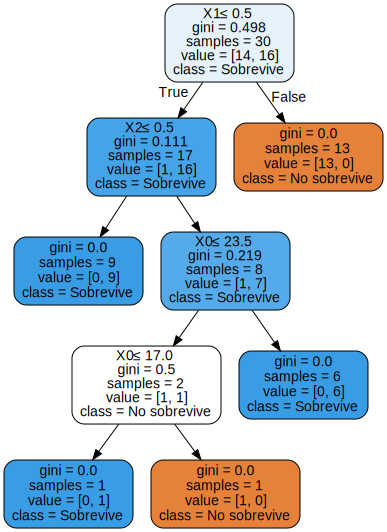

In [407]:
x = x_test.head(30).values
y = y_moda_predicted[0:30]
create_graph(x,y)

### Predicciones Probabilisticas

#### Modelo de Naive Bayes

In [412]:
bayes_model["mean"]

,Fare,passenger_sex_codes,passenger_class_codes
0,23.304731,0.828479,0.488673
1,49.328107,0.354497,1.037037


In [413]:
bayes_model["stdev"]

,Fare,passenger_sex_codes,passenger_class_codes
0,36.282155,0.376964,0.757295
1,68.091695,0.478361,0.875114


In [414]:
bayes_model["probabilities"]

,probabilities
0,0.620482
1,0.379518
